# Task A: PneumoniaMNIST

## 1. Import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os
import torch
import cv2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import OneHotEncoder

## 2. Feature engineering

In [29]:
# Get the data path
path = os.path.abspath(os.path.join('..', 'Datasets/pneumoniamnist.npz'))
print(path)

def data_process(path):
    # Get the dataset
    data = np.load(path)
    # Find the keys oof the dataset
    print(data.keys())
    # Extracting features and labels
    # Nomalization: dividing all features by 255
    train_X = data['train_images']/255.0
    train_y = data['train_labels']
    val_X = data['val_images']/255.0
    val_y = data['val_labels']
    test_X = data['test_images']/255.0
    test_y = data['test_labels']
    return train_X, train_y, val_X, val_y, test_X, test_y

# set the random seed to 42
torch.manual_seed(42)
train_X, train_y, val_X, val_y, test_X, test_y = data_process(path)
# create train_loader for training
train_tensor_X = torch.tensor(train_X, dtype=torch.float32).unsqueeze(1)

# One-hot encoder to process y
encoder = OneHotEncoder(sparse=False)
train_y = encoder.fit_transform(train_y)
print(train_y)

train_tensor_y = torch.tensor(train_y)
print(train_tensor_X.shape)
train_loader = DataLoader(TensorDataset(train_tensor_X, train_tensor_y), batch_size = 16, shuffle = True)
print(train_loader)
# create test_loader for testing
test_tensor_X = torch.tensor(test_X, dtype=torch.float32)
test_tensor_y = torch.tensor(encoder.fit_transform(test_y))
test_loader = DataLoader(TensorDataset(test_tensor_X, test_tensor_y), shuffle = False)

print(train_X.shape)


c:\Users\xrw\Desktop\UCL\APPLIED MACHINE LEARNING\AMLS_assignment23_24-\Datasets\pneumoniamnist.npz
KeysView(NpzFile 'c:\\Users\\xrw\\Desktop\\UCL\\APPLIED MACHINE LEARNING\\AMLS_assignment23_24-\\Datasets\\pneumoniamnist.npz' with keys: train_images, val_images, test_images, train_labels, val_labels...)
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]
torch.Size([4708, 1, 28, 28])
(4708, 28, 28)


d:\anaconda\envs\developing\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
d:\anaconda\envs\developing\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch: 1, train_loss: 174.005
Epoch: 1, Accuracy of the network on the train images: 74.21%
Epoch: 1, Accuracy of the network on the test images: 62.50%
Epoch: 1, test_loss: 413.094
Epoch: 2, train_loss: 149.553
Epoch: 2, Accuracy of the network on the train images: 74.21%
Epoch: 2, Accuracy of the network on the test images: 62.50%
Epoch: 2, test_loss: 381.432
Epoch: 3, train_loss: 127.827
Epoch: 3, Accuracy of the network on the train images: 80.56%
Epoch: 3, Accuracy of the network on the test images: 67.15%
Epoch: 3, test_loss: 332.956
Epoch: 4, train_loss: 106.351
Epoch: 4, Accuracy of the network on the train images: 87.62%
Epoch: 4, Accuracy of the network on the test images: 75.80%
Epoch: 4, test_loss: 292.869
Epoch: 5, train_loss: 88.553
Epoch: 5, Accuracy of the network on the train images: 90.87%
Epoch: 5, Accuracy of the network on the test images: 81.09%
Epoch: 5, test_loss: 262.070
Epoch: 6, train_loss: 76.824
Epoch: 6, Accuracy of the network on the train images: 91.82%


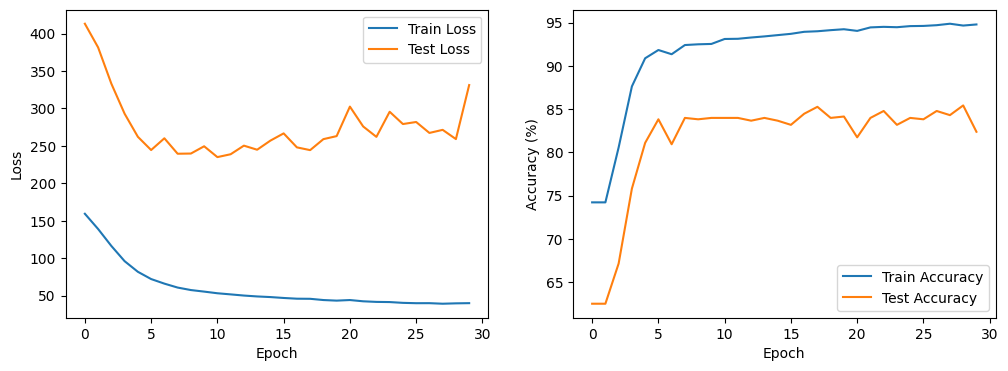

In [33]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = torch.relu(self.conv2(x))
        x = x.view(-1, 32 * 14 * 14)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_and_evaluate(model, train_loader, loss_criterion, optimizer, num_epoch, test_loader):
    train_accuracy_list = []
    test_accuracy_list = []
    train_loss_list = []
    test_loss_list = []
    for epoch_num in range(num_epoch):
        model.train()
        epoch_loss = 0.0
        for i, data in enumerate(train_loader):
            X, y = data
            optimizer.zero_grad()
            outputs = model(X)
            loss = loss_criterion(outputs, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch: {epoch_num + 1}, train_loss: {epoch_loss :.3f}')
        train_accuracy, train_loss = predict(model, train_loader, epoch_num, 'train')
        test_accuracy, test_loss = predict(model, test_loader, epoch_num, 'test')
        print(f'Epoch: {epoch_num + 1}, test_loss: {test_loss :.3f}')
        train_accuracy_list.append(train_accuracy)
        test_accuracy_list.append(test_accuracy)
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
    return train_accuracy_list, test_accuracy_list, train_loss_list, test_loss_list
    
# model : The model after training, 
# loader: The dataset need to be predicted by the model
# epoch_num: The number of the current epoch. 
# type: used to clarify which dataset is being predicted : (train, test, val)
def predict(model, loader, epoch_num, type):
    model.eval()
    correct = 0
    total = 0
    epoch_loss = 0
    with torch.no_grad():
        for i, samples in enumerate(loader):
            X, y = samples
            outputs = model(X)
            loss = loss_criterion(outputs, y)
            _, predicted = torch.max(outputs.data, axis = 1)
            total += y.size(0)
            # train_loader is encoded for training, while others are not encoded. y is different in these three different datasets([1,0] in train_loader or [0] in others)
            correct += (predicted == np.argmax(y,axis = 1)).sum().item()
            epoch_loss += loss
    # print(correct)
    print(f'Epoch: {epoch_num + 1}, Accuracy of the network on the {type} images: {100 * correct / total:.2f}%')
    return 100 * correct / total, epoch_loss

def plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()
    
type = ['train', 'test', 'val']
model = CNN() 
# Use CrossEntropyLoss to train the model
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
train_accuracy, test_accuracy, train_loss, test_loss = train_and_evaluate(model, train_loader, loss_criterion, optimizer, 30, test_loader)
plot_metrics(train_loss, train_accuracy, test_loss, test_accuracy)
# trained_model = train(model,train_loader, loss_criterion, optimizer, 30)
# predict(trained_model, test_loader)